In [1]:
#%%
import gym
import gym_chess
import chess
from chess import Board
from irlc.ex03.multisearch_agents import MultiAgentSearchAgent, MultiSearchProblem
import numpy as np
import time
from functools import partial

gym.envs.registry.all()
True

True

In [2]:
piece_value = {'p': -1, 'P': 1, 'k': 0, 'K': 0, 'q': -9, 'Q': 9, 'n': -3, 'N': 3, 'b': -3, 'B': 3, 'r': -5, 'R': 5}
neutral_piece_value = {None: 0, 'p': 1, 'P': 1, 'k': 1000, 'K': 1000, 'q': 9, 'Q': 9, 'n': 3, 'N': 3, 'b': 3, 'B': 3, 'r': 5, 'R': 5}


def eval_move(u, b):
    piece = b.piece_at(u.to_square)
    piece_val = 0
    if piece is not None:
        piece_val += neutral_piece_value[piece.symbol()]
    if u.promotion is not None:
        piece_val += 100
    relative_rank = chess.square_rank(u.to_square) - chess.square_rank(u.from_square)
    if b.turn:
        piece_val += 0.1 * (relative_rank > 0)
    else:
        piece_val += 0.1 * (relative_rank < 0)
    return piece_val


state_cache = {}


def static_eval(state):
    cleaned = str(state)  #.replace("\n", "").replace(".", "").replace(" ", "")
    if cleaned not in state_cache:
        ssum = 0
        for letter in cleaned:
            if not any(letter == o for o in ['.', " ", '\n']):
                ssum += piece_value[letter]
            #if letter.isupper():
            #	white.append(letter)
            #if letter.islower():
            #	black.append(letter)
        state_cache[cleaned] = ssum
    else:
        ssum = state_cache[cleaned]
    return ssum


class ChessMultisearchModel(MultiSearchProblem):

    def __init__(self):
        self.num_expanded = 0

    def utility(self, board):
        return static_eval(board)

    def get_players(self):
        return 2

    def actions(self, board):
        eval_move_b = partial(eval_move, b=board)
        actions = sorted(board.legal_moves, key=eval_move_b, reverse=True)
        return actions

    def get_successor(self, action, board):
        self.num_expanded += 1
        new_board = Board(board.fen())
        new_board.push(action)
        return new_board


result_reward = {'1-0': 10000, '0-1': -10000, '1/2-1/2': 0}


class GymAlphaBetaAgent(MultiAgentSearchAgent):
    """ Implement alpha-beta search as defined in (Her21, Algorithm 17)"""

    def __init__(self, env, depth=1):
        super().__init__(env, depth)
        self.model = ChessMultisearchModel()

    def multisearch_evaluate(self, state):
        return self.alpha_beta(state, self.depth, alpha=-np.inf, beta=np.inf)

    def alpha_beta(self, x, d: int, alpha: float, beta: float):
        self.player = 1 if x.turn else -1
        return self.MaxValue(x, d, alpha, beta)

    def MaxValue(self, x, d, alpha, beta):
        maxScore = -np.inf
        maxAction = None

        for u in self.model.actions(x):
            successor = self.model.get_successor(u, x)

            result = successor.result()
            if result in ['1-0', '0-1', '1/2-1/2']:
                score = self.player * (result_reward[result]-(self.depth-d))
            elif d == 0:
                score = self.player * self.model.utility(x)
            else:
                score, _ = self.MinValue(successor, d, alpha, beta)

            if score >= beta:
                return score, u
            if score > maxScore:
                maxScore, maxAction = score, u
                alpha = max(alpha, maxScore)
        return maxScore, maxAction

    def MinValue(self, x, d, alpha, beta):
        minScore = np.inf
        minAction = None

        for u in self.model.actions(x):
            successor = self.model.get_successor(u, x)

            result = successor.result()
            if result in ['1-0', '0-1', '1/2-1/2']:
                score = self.player * (result_reward[result]-(self.depth-d))
            elif d == 0:
                print("This shouldn't happen")
                #score = self.player * self.model.utility(x)
            else:
                score, _ = self.MaxValue(successor, d - 1, alpha, beta)

            if score <= alpha:
                return score, u
            if score < minScore:
                minScore, minAction = score, u
                beta = min(beta, minScore)
        return minScore, minAction

    def __str__(self):
        return f"AlphaBetaAgent_{self.depth}"


class GymMonteCarloSearchAgent(MultiAgentSearchAgent):
    """ Implement alpha-beta search as defined in (Her21, Algorithm 17)"""

    def __init__(self, env, depth=1, n_tries=100):
        super().__init__(env, depth)
        self.model = ChessMultisearchModel()
        self.n_tries = n_tries

    def multisearch_evaluate(self, state):
        return self.monte_carlo(state)

    def monte_carlo(self, x):
        self.player = 1 if x.turn else -1
        actions = self.model.actions(x)
        a_sum = np.zeros((len(actions),))
        for _ in range(self.n_tries):
            for i, u in enumerate(actions):
                b = self.model.get_successor(u, x)
                for _ in range(self.depth):
                    if b.result() in ['1-0', '0-1', '1/2-1/2']:
                        a_sum[i] += self.player * result_reward[b.result()]
                        break
                    b.push(np.random.choice(list(b.legal_moves)))
                    self.model.num_expanded += 1
                a_sum[i] += self.player * self.model.utility(b)
        max_index = np.argmax(a_sum)
        return a_sum[max_index], actions[max_index]

    def __str__(self):
        return f"MonteCarloSearchAgent_{self.depth}_{self.n_tries}"

In [3]:
env = gym.make('Chess-v0')
fen_str = '2rqkb2/2pppp2/8/8/8/8/2PPPP2/2RQKB2 w - - 0 1'

In [4]:
from collections import defaultdict
board_utilities = defaultdict(lambda: [])
agent1_scores = defaultdict(lambda: [])
agent2_scores = defaultdict(lambda: [])
agent1_num_expanded = defaultdict(lambda: [])
agent2_num_expanded = defaultdict(lambda: [])

In [5]:
agent1 = GymAlphaBetaAgent(env, depth=1)
agent2 = GymMonteCarloSearchAgent(env, depth=1, n_tries=1000)  #GymMonteCarloSearchAgent(env, depth=20, n_tries=100)

scheme = f"{agent1}-vs-{agent2}"

env.reset()
env._board.set_fen(fen_str)  #'8/8/2n1kn2/3pp3/3PP3/2NK1N2/8/8 w - - 0 1')
start = time.time()
done = False
while not done:
    if env._board.turn:
        score, move = agent1.multisearch_evaluate(env._board)
        print(f"Player {str(agent1)}_{int(env._board.turn)}: {score}, {move}")
        agent1_scores[scheme].append(score)
        agent1_num_expanded[scheme].append(agent1.model.num_expanded)
    else:
        score, move = agent2.multisearch_evaluate(env._board)
        print(f"Player {str(agent2)}_{int(env._board.turn)}: {score}, {move}")
        agent2_scores[scheme].append(score)
        agent2_num_expanded[scheme].append(agent2.model.num_expanded)
    state, reward, done, info = env.step(move)
    board_utilities[scheme].append(static_eval(env._board))
    print(env._board)
    print("")
print(env._board.result())
end = time.time()
print(end - start)

Player AlphaBetaAgent_1_1: 0, f1h3
. . r q k b . .
. . p p p p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . B
. . P P P P . .
. . R Q K . . .

Player MonteCarloSearchAgent_1_1000_0: -52.0, f8g7
. . r q k . . .
. . p p p p b .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . B
. . P P P P . .
. . R Q K . . .

Player AlphaBetaAgent_1_1: 0, h3f5
. . r q k . . .
. . p p p p b .
. . . . . . . .
. . . . . B . .
. . . . . . . .
. . . . . . . .
. . P P P P . .
. . R Q K . . .

Player MonteCarloSearchAgent_1_1000_0: -45.0, g7e5
. . r q k . . .
. . p p p p . .
. . . . . . . .
. . . . b B . .
. . . . . . . .
. . . . . . . .
. . P P P P . .
. . R Q K . . .

Player AlphaBetaAgent_1_1: 0, f5h7
. . r q k . . .
. . p p p p . B
. . . . . . . .
. . . . b . . .
. . . . . . . .
. . . . . . . .
. . P P P P . .
. . R Q K . . .

Player MonteCarloSearchAgent_1_1000_0: 0.0, e5f4
. . r q k . . .
. . p p p p . B
. . . . . . . .
. . . . . . . .
. . . . . b . .
. . . . . . . .
. .

In [6]:
agent1 = GymAlphaBetaAgent(env, depth=2)
agent2 = GymMonteCarloSearchAgent(env, depth=2, n_tries=1000)  #GymMonteCarloSearchAgent(env, depth=20, n_tries=100)

scheme = f"{agent1}-vs-{agent2}"

env.reset()
env._board.set_fen(fen_str)  #'8/8/2n1kn2/3pp3/3PP3/2NK1N2/8/8 w - - 0 1')
start = time.time()
done = False
while not done:
    if env._board.turn:
        score, move = agent1.multisearch_evaluate(env._board)
        print(f"Player {str(agent1)}_{int(env._board.turn)}: {score}, {move}")
        agent1_scores[scheme].append(score)
        agent1_num_expanded[scheme].append(agent1.model.num_expanded)
    else:
        score, move = agent2.multisearch_evaluate(env._board)
        print(f"Player {str(agent2)}_{int(env._board.turn)}: {score}, {move}")
        agent2_scores[scheme].append(score)
        agent2_num_expanded[scheme].append(agent2.model.num_expanded)
    state, reward, done, info = env.step(move)
    board_utilities[scheme].append(static_eval(env._board))
    print(env._board)
    print("")
print(env._board.result())
end = time.time()
print(end - start)

Player AlphaBetaAgent_2_1: 0, e2e3
. . r q k b . .
. . p p p p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R Q K B . .

Player MonteCarloSearchAgent_2_1000_0: 62.0, f8h6
. . r q k . . .
. . p p p p . .
. . . . . . . b
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R Q K B . .

Player AlphaBetaAgent_2_1: 0, d1h5
. . r q k . . .
. . p p p p . .
. . . . . . . b
. . . . . . . Q
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R . K B . .

Player MonteCarloSearchAgent_2_1000_0: 374.0, h6g7
. . r q k . . .
. . p p p p b .
. . . . . . . .
. . . . . . . Q
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R . K B . .

Player AlphaBetaAgent_2_1: 0, h5h7
. . r q k . . .
. . p p p p b Q
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R . K B . .

Player MonteCarloSearchAgent_2_1000_0: 734.0, e8f8
. . r q . k . .
. . p p p p b Q
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
. 

In [7]:
agent1 = GymAlphaBetaAgent(env, depth=3)
agent2 = GymMonteCarloSearchAgent(env, depth=3, n_tries=1000)  #GymMonteCarloSearchAgent(env, depth=20, n_tries=100)

scheme = f"{agent1}-vs-{agent2}"

env.reset()
env._board.set_fen(fen_str)  #'8/8/2n1kn2/3pp3/3PP3/2NK1N2/8/8 w - - 0 1')
start = time.time()
done = False
while not done:
    if env._board.turn:
        score, move = agent1.multisearch_evaluate(env._board)
        print(f"Player {str(agent1)}_{int(env._board.turn)}: {score}, {move}")
        agent1_scores[scheme].append(score)
        agent1_num_expanded[scheme].append(agent1.model.num_expanded)
    else:
        score, move = agent2.multisearch_evaluate(env._board)
        print(f"Player {str(agent2)}_{int(env._board.turn)}: {score}, {move}")
        agent2_scores[scheme].append(score)
        agent2_num_expanded[scheme].append(agent2.model.num_expanded)
    state, reward, done, info = env.step(move)
    board_utilities[scheme].append(static_eval(env._board))
    print(env._board)
    print("")
print(env._board.result())
end = time.time()
print(end - start)

Player AlphaBetaAgent_3_1: 0, e2e3
. . r q k b . .
. . p p p p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R Q K B . .

Player MonteCarloSearchAgent_3_1000_0: 9.0, f8h6
. . r q k . . .
. . p p p p . .
. . . . . . . b
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R Q K B . .

Player AlphaBetaAgent_3_1: 0, d1h5
. . r q k . . .
. . p p p p . .
. . . . . . . b
. . . . . . . Q
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R . K B . .

Player MonteCarloSearchAgent_3_1000_0: 267.0, h6g7
. . r q k . . .
. . p p p p b .
. . . . . . . .
. . . . . . . Q
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R . K B . .

Player AlphaBetaAgent_3_1: 0, h5h7
. . r q k . . .
. . p p p p b Q
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R . K B . .

Player MonteCarloSearchAgent_3_1000_0: 750.0, e8f8
. . r q . k . .
. . p p p p b Q
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
. .

In [ ]:
agent1 = GymAlphaBetaAgent(env, depth=3)
agent2 = GymMonteCarloSearchAgent(env, depth=20, n_tries=100)  #GymMonteCarloSearchAgent(env, depth=20, n_tries=100)

scheme = f"{agent1}-vs-{agent2}"

env.reset()
env._board.set_fen(fen_str)  #'8/8/2n1kn2/3pp3/3PP3/2NK1N2/8/8 w - - 0 1')
start = time.time()
done = False
while not done:
    if env._board.turn:
        score, move = agent1.multisearch_evaluate(env._board)
        print(f"Player {str(agent1)}_{int(env._board.turn)}: {score}, {move}")
        agent1_scores[scheme].append(score)
        agent1_num_expanded[scheme].append(agent1.model.num_expanded)
    else:
        score, move = agent2.multisearch_evaluate(env._board)
        print(f"Player {str(agent2)}_{int(env._board.turn)}: {score}, {move}")
        agent2_scores[scheme].append(score)
        agent2_num_expanded[scheme].append(agent2.model.num_expanded)
    state, reward, done, info = env.step(move)
    board_utilities[scheme].append(static_eval(env._board))
    print(env._board)
    print("")
print(env._board.result())
end = time.time()
print(end - start)

Player AlphaBetaAgent_3_1: 0, e2e3
. . r q k b . .
. . p p p p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R Q K B . .

Player MonteCarloSearchAgent_20_100_0: 12.0, e7e6
. . r q k b . .
. . p p . p . .
. . . . p . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R Q K B . .

Player AlphaBetaAgent_3_1: -1, f1a6
. . r q k b . .
. . p p . p . .
B . . . p . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R Q K . . .

Player MonteCarloSearchAgent_20_100_0: 9865.0, e6e5
. . r q k b . .
. . p p . p . .
B . . . . . . .
. . . . p . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R Q K . . .

Player AlphaBetaAgent_3_1: 2, a6c8
. . B q k b . .
. . p p . p . .
. . . . . . . .
. . . . p . . .
. . . . . . . .
. . . . P . . .
. . P P . P . .
. . R Q K . . .

Player MonteCarloSearchAgent_20_100_0: 9659.0, e5e4
. . B q k b . .
. . p p . p . .
. . . . . . . .
. . . . . . . .
. . . . p . . .
. . . . P . . .

In [ ]:
class GymMinimaxAgent(MultiAgentSearchAgent):
    """ Implement alpha-beta search as defined in (Her21, Algorithm 17)"""

    def __init__(self, env, depth=1):
        super().__init__(env, depth)
        self.model = ChessMultisearchModel()

    def multisearch_evaluate(self, state):
        return self.minimax(state, self.depth)  # return (optimal score, optimal action)

    def minimax(self, x, d):  # q is current player, d is depth (same as in code)
        result = x.result()
        if result in ['1-0', '0-1', '1/2-1/2']:
            return self.player * result_reward[result], None
        elif d == 0:
            return self.player * self.model.utility(x), None

        V = {}
        for action in self.model.actions(x):
            V[action], _ = self.minimax(self.model.get_successor(action, x), d - 1)

        best_action = max(V, key=V.get) if x.turn else min(V, key=V.get)  # I use a dictionary V[a] = expected utility.
        return V[best_action], best_action

In [12]:
from matplotlib import pyplot as plt

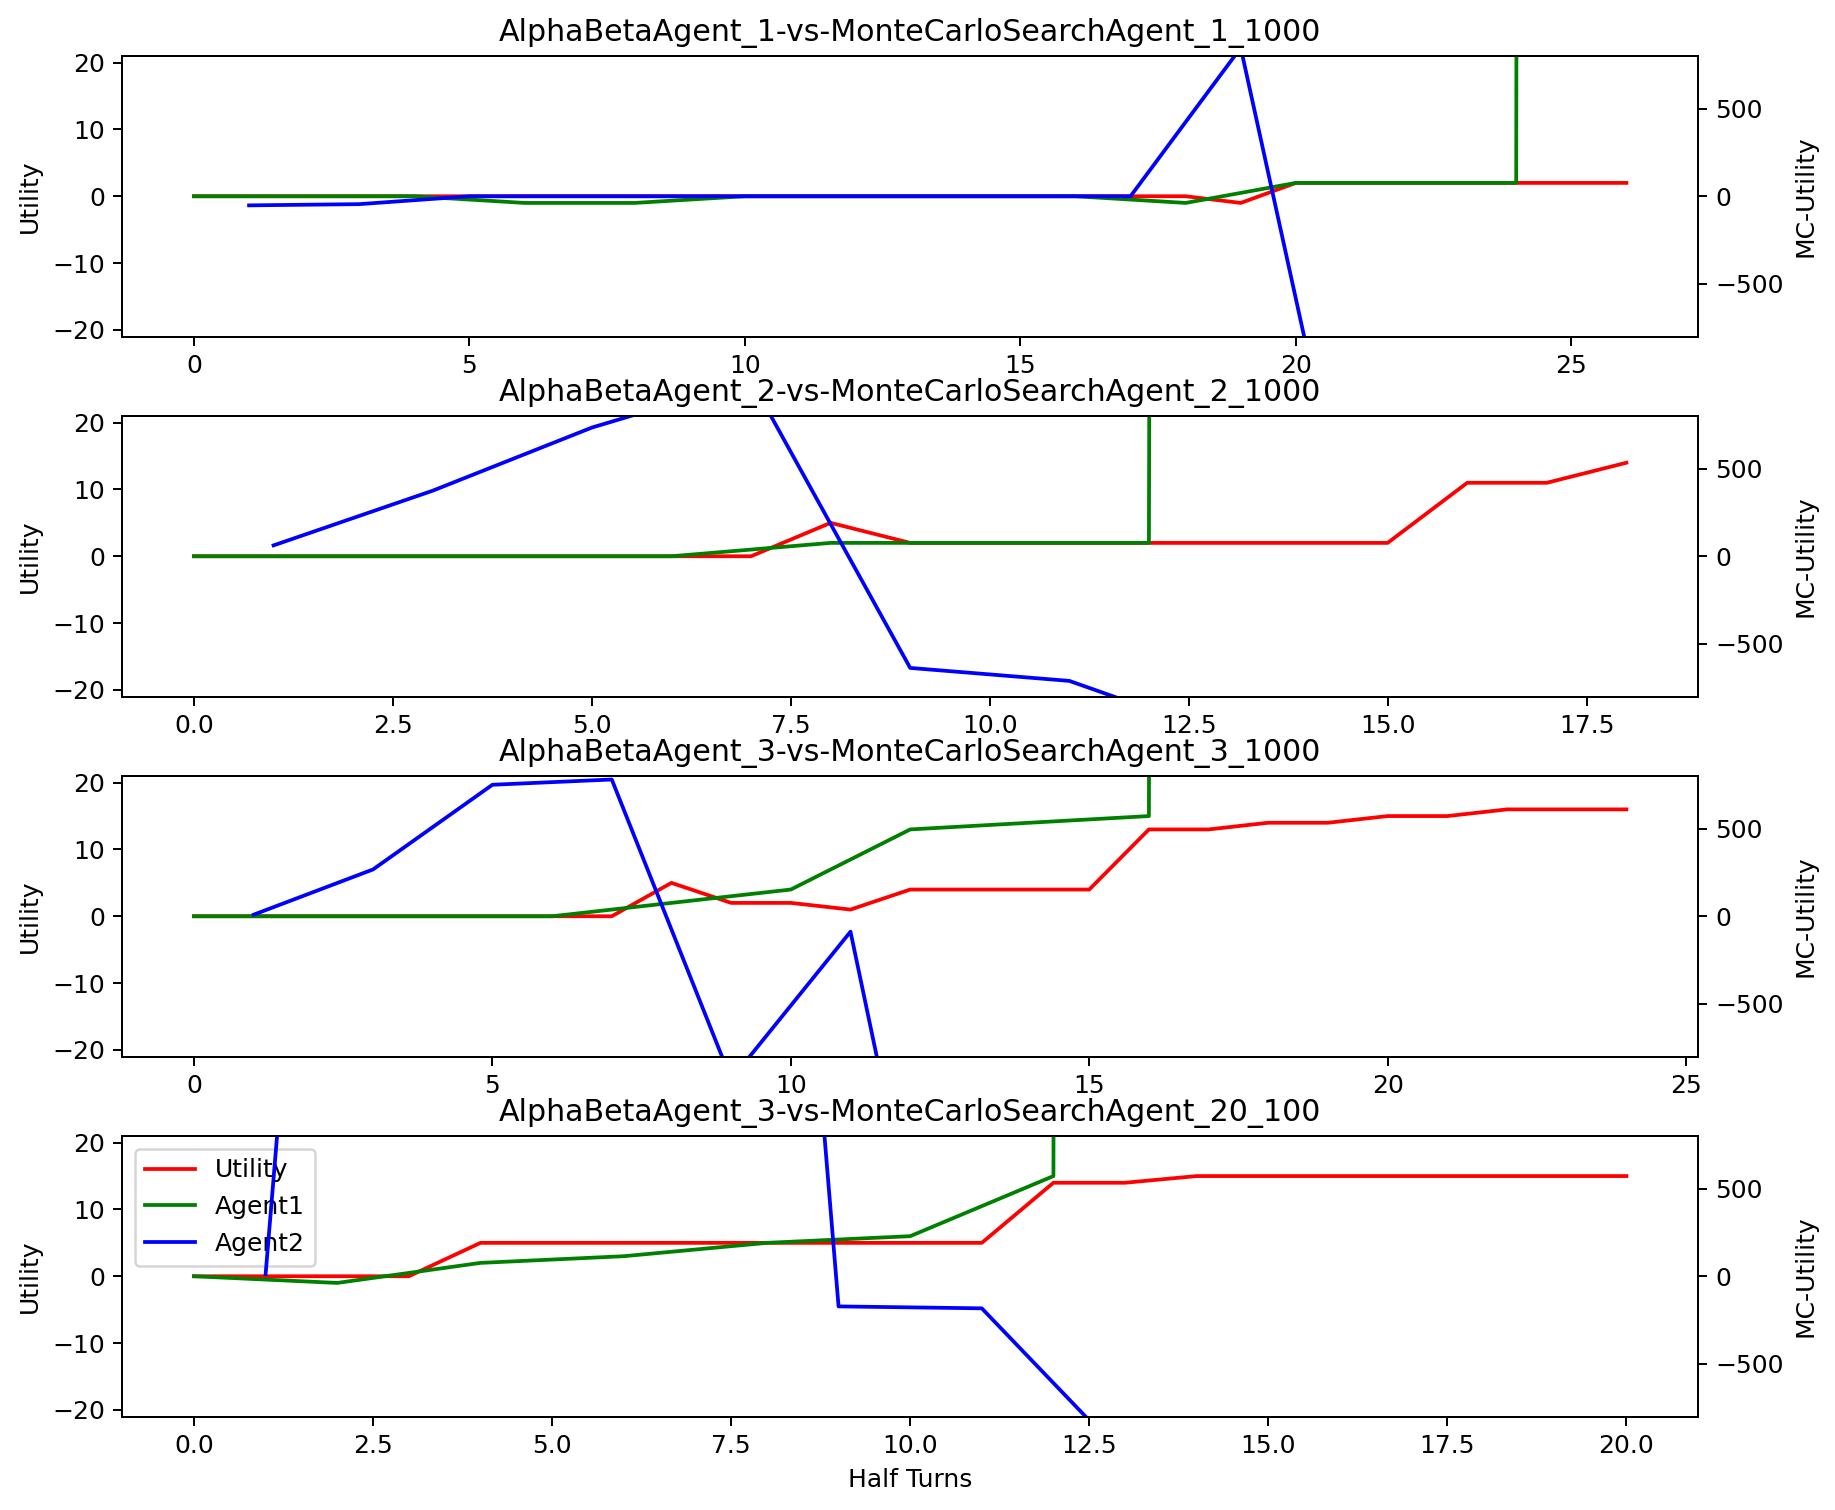

In [43]:
fig, axs = plt.subplots(4,1, figsize=(10,8), dpi=180)
for k,ax in zip(board_utilities,axs.flatten()):
    N = len(board_utilities[k])
    ax.set_title(k)
    uplt = ax.plot(range(N), board_utilities[k], c='r', label='Utility')
    a1plt = ax.plot(range(0,N,2), agent1_scores[k], c='g', label='Agent1')
    ax.set_ylim([-21,21])
    ax.set_ylabel('Utility')
    secax = ax.twinx()
    a2plt = secax.plot(range(1,N,2), agent2_scores[k], c='b', label='Agent2')
    secax.set_ylim([-800,800])
    secax.set_ylabel('MC-Utility')
lplts = uplt+a1plt+a2plt
labels = [l.get_label() for l in lplts]
ax.legend(lplts, labels)
plt.tight_layout(pad=0,h_pad=0,w_pad=0)
ax.set_xlabel('Half Turns')
plt.savefig('gameresults.pdf')

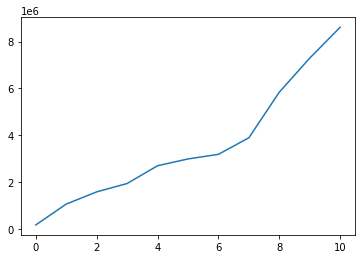

In [14]:
plt.plot(agent1_num_expanded['AlphaBetaAgent_3-vs-MonteCarloSearchAgent_20_100'])

In [15]:
board_utilities.keys()

dict_keys(['AlphaBetaAgent_1-vs-MonteCarloSearchAgent_1_1000', 'AlphaBetaAgent_2-vs-MonteCarloSearchAgent_2_1000', 'AlphaBetaAgent_3-vs-MonteCarloSearchAgent_3_1000', 'AlphaBetaAgent_3-vs-MonteCarloSearchAgent_20_100'])